In [16]:
import pandas as pd

# numeric functions
import numpy as np
from scipy import stats
from math import ceil

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# modelling
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures

In [17]:
df_train = pd.read_csv('../train.csv',index_col='Id')
df_test = pd.read_csv('../test.csv',index_col='Id')

# ids of full training dataset
id_train = df_train.index

# ids of full test dataset
id_test = df_test.index

# combine train and test datas in to one dataframe
df_all = pd.concat([df_train,df_test])
df_all.head(5)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
2,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
3,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
4,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
5,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


In [18]:
print('train.shape=', df_train.shape, ', test.shape=', df_test.shape)

train.shape= (1460, 80) , test.shape= (1459, 79)


In [19]:
def get_cols_with_na(df):
    cols_with_na = df.isnull().sum()
    cols_with_na = cols_with_na[cols_with_na>0]
    return cols_with_na

In [20]:
cols_with_na = get_cols_with_na(df_all.drop('SalePrice', axis=1))

In [21]:
print(cols_with_na.sort_values(ascending=False).to_string())

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageArea         1
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1


## Meaningful NaN Values

In [22]:
# columns where NaN values have meaning e.g. no pool etc.
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2']

# replace 'NaN' with 'None' in these columns
for col in cols_fillna:
    df_all[col].fillna('None',inplace=True)
    
#GarageYrBlt nans: no garage. Fill with property YearBuilt.
#(more appropriate than 0, which would be ~2000 away from all other values)
df_all.loc[df_all.GarageYrBlt.isnull(),'GarageYrBlt'] = df_all.loc[df_all.GarageYrBlt.isnull(),'YearBuilt']

#No masonry veneer - fill area with 0
df_all.MasVnrArea.fillna(0,inplace=True)

#No basement - fill areas/counts with 0    
df_all.BsmtFullBath.fillna(0,inplace=True)
df_all.BsmtHalfBath.fillna(0,inplace=True)
df_all.BsmtFinSF1.fillna(0,inplace=True)
df_all.BsmtFinSF2.fillna(0,inplace=True)
df_all.BsmtUnfSF.fillna(0,inplace=True)
df_all.TotalBsmtSF.fillna(0,inplace=True)

#No garage - fill areas/counts with 0
df_all.GarageArea.fillna(0,inplace=True)
df_all.GarageCars.fillna(0,inplace=True)

## LotFrontage NaN Values

In [23]:
# function to normalise a column of values to lie between 0 and 1
def scale_minmax(col):
    return (col-col.min())/(col.max()-col.min())

----------------
Intercept: 93.20848325398028
----------------head(10)
LotArea             71.475879
RoofMatl_ClyTile    49.396968
1stFlrSF            27.547832
PoolArea            26.905146
RoofStyle_Shed      25.874524
GrLivArea           22.148975
Foundation_Wood     20.075497
LotShape_IR3        17.721471
GarageArea          17.536239
BldgType_2fmCon     16.123235
dtype: float64
----------------tail(10)
Utilities_AllPub      -11.610027
BldgType_TwnhsE       -12.070870
BsmtCond_Po           -12.151678
Exterior1st_CemntBd   -14.553347
PoolQC_Fa             -14.706527
RoofMatl_WdShake      -15.579127
BldgType_Twnhs        -17.924473
RoofMatl_WdShngl      -18.222015
GarageYrBlt           -21.591319
LotConfig_CulDSac     -23.428742
dtype: float64
----------------
R2: 0.6889229361774905
----------------


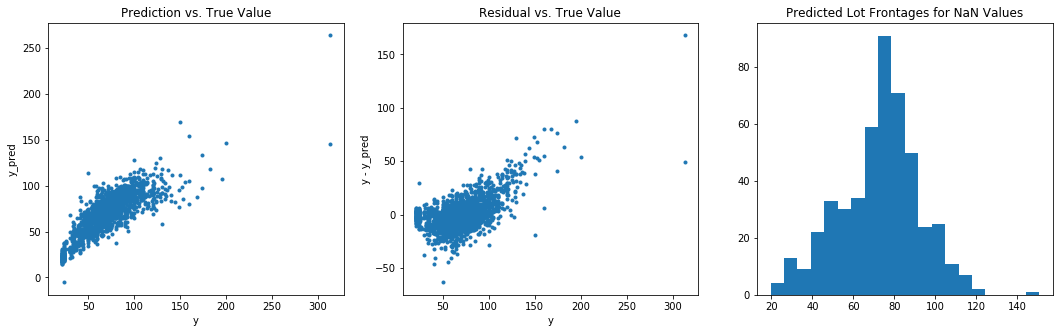

In [24]:
#LotFrontage
# fill nan values using a linear regressor

# convert categoricals to dummies, exclude SalePrice from model
df_frontage = pd.get_dummies(df_all.drop('SalePrice',axis=1))

# normalise columns to 0-1
for col in df_frontage.drop('LotFrontage',axis=1).columns:
    df_frontage[col] = scale_minmax(df_frontage[col])

lf_train = df_frontage.dropna()
lf_train_y = lf_train.LotFrontage
lf_train_X = lf_train.drop('LotFrontage',axis=1)  

# fit model
lr = Ridge()
lr.fit(lf_train_X, lf_train_y)

# check model results
lr_coefs = pd.Series(lr.coef_,index=lf_train_X.columns)

print('----------------')
print('Intercept:',lr.intercept_)
print('----------------head(10)')
print(lr_coefs.sort_values(ascending=False).head(10))
print('----------------tail(10)')
print(lr_coefs.sort_values(ascending=False).tail(10))
print('----------------')
print('R2:',lr.score(lf_train_X,lf_train_y))
print('----------------')

lf_pred_y = lr.predict(lf_train_X)
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.plot(lf_train_y,lf_pred_y,'.')
plt.xlabel('y')
plt.ylabel('y_pred');
plt.title('Prediction vs. True Value')

plt.subplot(1,3,2)
plt.plot(lf_train_y, lf_train_y-lf_pred_y,'.')
plt.xlabel('y')
plt.ylabel('y - y_pred');
plt.title('Residual vs. True Value')


# fill na values using model predictions
nan_frontage = df_all.LotFrontage.isnull()
X = df_frontage[nan_frontage].drop('LotFrontage',axis=1)
y = lr.predict(X)

plt.subplot(1,3,3)
plt.hist(y,bins=20)
plt.title('Predicted Lot Frontages for NaN Values')

# fill nan values
df_all.loc[nan_frontage,'LotFrontage'] = y

## Remaining NaNs

In [25]:
print(cols_with_na.sort_values(ascending=False).to_string())

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageArea         1
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1


In [26]:
rows_with_na = df_all.drop('SalePrice',axis=1).isnull().sum(axis=1)
rows_with_na = rows_with_na[rows_with_na>0]
print(rows_with_na.sort_values(ascending=False).to_string())

Id
2217    2
2152    2
1916    2
2905    1
2490    1
2474    1
2251    1
1946    1
1556    1
1380    1


In [27]:
# fill remaining nans with mode in that column
for col in cols_with_na.index:
    df_all[col].fillna(df_all[col].mode()[0], inplace=True)
# check nans    
df_all.drop('SalePrice', axis=1).isnull().sum().max() 

0

In [28]:
# Now no more NaN values
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 80 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
Alley            2919 non-null object
BedroomAbvGr     2919 non-null int64
BldgType         2919 non-null object
BsmtCond         2919 non-null object
BsmtExposure     2919 non-null object
BsmtFinSF1       2919 non-null float64
BsmtFinSF2       2919 non-null float64
BsmtFinType1     2919 non-null object
BsmtFinType2     2919 non-null object
BsmtFullBath     2919 non-null float64
BsmtHalfBath     2919 non-null float64
BsmtQual         2919 non-null object
BsmtUnfSF        2919 non-null float64
CentralAir       2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
Electrical       2919 non-null object
EnclosedPorch    2919 non-null int64
ExterCond        2919 non-null object
ExterQual        2919 non-null object
Exterior1st      29

## Basement Finish Types

In [29]:
# create separate columns for area of each possible
# basement finish type
bsmt_fin_cols = ['BsmtGLQ','BsmtALQ','BsmtBLQ',
                 'BsmtRec','BsmtLwQ']

for col in bsmt_fin_cols:
    # initialise as columns of zeros
    df_all[col+'SF'] = 0

# fill remaining finish type columns
for row in df_all.index:
    fin1 = df_all.loc[row,'BsmtFinType1']
    if (fin1!='None') and (fin1!='Unf'):
        # add area (SF) to appropriate column
        df_all.loc[row,'Bsmt'+fin1+'SF'] += df_all.loc[row,'BsmtFinSF1']
        
    fin2 = df_all.loc[row,'BsmtFinType2']
    if (fin2!='None') and (fin2!='Unf'):
        df_all.loc[row,'Bsmt'+fin2+'SF'] += df_all.loc[row,'BsmtFinSF2']


# remove initial BsmtFin columns
df_all.drop(['BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2'], axis=1, inplace=True)

# already have BsmtUnf column in dataset
bsmt_fin_cols.append('BsmtUnf')

# also create features representing the fraction of the basement that is each finish type
for col in bsmt_fin_cols:
    df_all[col+'Frac'] = df_all[col+'SF']/df_all['TotalBsmtSF']
    # replace any nans with zero (for properties without a basement)
    df_all[col+'Frac'].fillna(0,inplace=True)
    
# check nans    
df_all.drop('SalePrice', axis=1).isnull().sum().max() 

0

,BsmtCond,BsmtExposure,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF,BsmtGLQSF,BsmtALQSF,BsmtBLQSF,BsmtRecSF,BsmtLwQSF,BsmtGLQFrac,BsmtALQFrac,BsmtBLQFrac,BsmtRecFrac,BsmtLwQFrac,BsmtUnfFrac
Id,,,,,,,,,,,,,,,,,,
1,TA,No,1.0,0.0,Gd,150.0,856.0,706.0,0.0,0.0,0.0,0.0,0.824766,0.000000,0.0,0.0,0.0,0.175234
2,TA,Gd,0.0,1.0,Gd,284.0,1262.0,0.0,978.0,0.0,0.0,0.0,0.000000,0.774960,0.0,0.0,0.0,0.225040
3,TA,Mn,1.0,0.0,Gd,434.0,920.0,486.0,0.0,0.0,0.0,0.0,0.528261,0.000000,0.0,0.0,0.0,0.471739
4,Gd,No,1.0,0.0,TA,540.0,756.0,0.0,216.0,0.0,0.0,0.0,0.000000,0.285714,0.0,0.0,0.0,0.714286
5,TA,Av,1.0,0.0,Gd,490.0,1145.0,655.0,0.0,0.0,0.0,0.0,0.572052,0.000000,0.0,0.0,0.0,0.427948


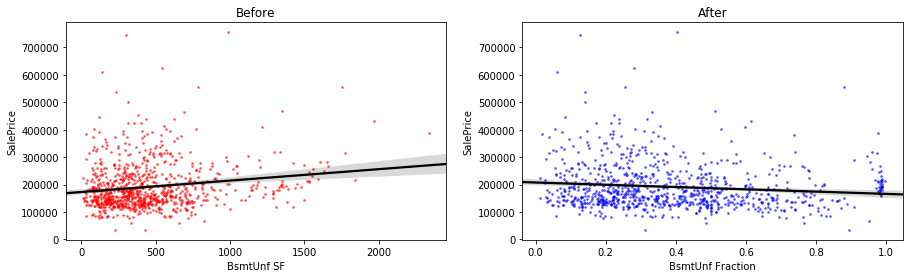

In [30]:
#plot to demonstrate the effect of the new feature
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
sns.regplot(df_all.loc[(df_all['BsmtUnfFrac']>0) & (df_all['BsmtUnfFrac']<1), 'BsmtUnfSF'],
            df_all.loc[(df_all['BsmtUnfFrac']>0) & (df_all['BsmtUnfFrac']<1), 'SalePrice'],
            scatter_kws={'marker':'.','s':3,'alpha':0.5,'color':'r'},
            line_kws={'color':'k'})

plt.xlabel('BsmtUnf SF')
plt.title('Before')

plt.subplot(1,2,2)
sns.regplot(df_all.loc[(df_all['BsmtUnfFrac']>0) & (df_all['BsmtUnfFrac']<1), 'BsmtUnfFrac'],
            df_all.loc[(df_all['BsmtUnfFrac']>0) & (df_all['BsmtUnfFrac']<1), 'SalePrice'],            
            scatter_kws={'marker':'.','s':3,'alpha':0.5,'color':'b'},
            line_kws={'color':'k'})

plt.xlabel('BsmtUnf Fraction')
plt.title('After')


df_all.loc[:,df_all.columns.str.contains('Bsmt')].head(5)

## 1st and 2nd Floor Area
### TotalAreaSF for the total size of all interior areas, LivingAreaSF for the total area of living quarters (including any in the basement), and StorageAreaSF for total area of non-living quarter interiors (garage etc.)

In [31]:
df_all['LowQualFinFrac'] = df_all['LowQualFinSF']/df_all['GrLivArea']
df_all['1stFlrFrac'] = df_all['1stFlrSF']/df_all['GrLivArea']
df_all['2ndFlrFrac'] = df_all['2ndFlrSF']/df_all['GrLivArea']

df_all['TotalAreaSF'] = df_all['GrLivArea']+df_all['TotalBsmtSF']+df_all['GarageArea']+df_all['EnclosedPorch']+df_all['ScreenPorch']
df_all['LivingAreaSF'] = df_all['1stFlrSF'] + df_all['2ndFlrSF'] + df_all['BsmtGLQSF'] + df_all['BsmtALQSF'] + df_all['BsmtBLQSF']
df_all['StorageAreaSF'] = df_all['LowQualFinSF'] + df_all['BsmtRecSF'] + df_all['BsmtLwQSF'] + df_all['BsmtUnfSF'] + df_all['GarageArea']

## Categorical Features with Meaningful Ordering

In [32]:
# convert some categorical values to numeric scales

#Excellent, Good, Typical, Fair, Poor, None: Convert to 0-5 scale
cols_ExGd = ['ExterQual','ExterCond','BsmtQual','BsmtCond',
             'HeatingQC','KitchenQual','FireplaceQu','GarageQual',
            'GarageCond','PoolQC']

dict_ExGd = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0}

for col in cols_ExGd:
    df_all[col].replace(dict_ExGd, inplace=True)

display(df_all[cols_ExGd].head(5))    

# Remaining columns
df_all['BsmtExposure'].replace({'Gd':4,'Av':3,'Mn':2,'No':1,'None':0}, inplace=True)

df_all['CentralAir'].replace({'Y':1,'N':0}, inplace=True)

df_all['Functional'].replace({'Typ':7,'Min1':6,'Min2':5,'Mod':4,'Maj1':3,'Maj2':2,'Sev':1,'Sal':0}, inplace=True)

df_all['GarageFinish'].replace({'Fin':3,'RFn':2,'Unf':1,'None':0}, inplace=True)

df_all['LotShape'].replace({'Reg':3,'IR1':2,'IR2':1,'IR3':0}, inplace=True)

df_all['Utilities'].replace({'AllPub':3,'NoSewr':2,'NoSeWa':1,'ELO':0}, inplace=True)

df_all['LandSlope'].replace({'Gtl':2,'Mod':1,'Sev':0}, inplace=True)

,ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond,PoolQC
Id,,,,,,,,,,
1,4,3,4,3,5,4,0,3,3,0
2,3,3,4,3,5,3,3,3,3,0
3,4,3,4,3,5,4,3,3,3,0
4,3,3,3,4,4,4,4,3,3,0
5,4,3,4,3,5,4,3,3,3,0


## Dealing with Zeros

In [33]:
# fraction of zeros in each column
frac_zeros = ((df_all==0).sum()/len(df_all))

# no. unique values in each column
n_unique = df_all.nunique()

# difference between frac. zeros and expected
# frac. zeros if values evenly distributed between
# classes
xs_zeros = frac_zeros - 1/n_unique

# create dataframe and display which columns may be problematic
zero_cols = pd.DataFrame({'frac_zeros':frac_zeros,'n_unique':n_unique,'xs_zeros':xs_zeros})
zero_cols = zero_cols[zero_cols.frac_zeros>0]
zero_cols.sort_values(by='xs_zeros',ascending=False,inplace=True)
display(zero_cols[(zero_cols.xs_zeros>0)])

#very few properties with Pool or 3SsnPorch
#replace columns with binary indicator
df_all['HasPool'] = (df_all['PoolQC']>0).astype(int)
df_all['Has3SsnPorch'] = (df_all['3SsnPorch']>0).astype(int)
df_all.drop(['PoolQC','PoolArea','3SsnPorch'],axis=1,inplace=True)

# 'half' bathrooms - add half value to 'full' bathrooms
df_all['BsmtFullBath'] = df_all['BsmtFullBath'] + 0.5*df_all['BsmtHalfBath']
df_all['FullBath'] = df_all['FullBath'] + 0.5*df_all['HalfBath']
df_all.drop(['BsmtHalfBath','HalfBath'],axis=1,inplace=True)

# create additional dummy variable for
# continuous variables with a lot of zeros
dummy_cols = ['LowQualFinSF','2ndFlrSF',
              'MiscVal','ScreenPorch','WoodDeckSF','OpenPorchSF',
              'EnclosedPorch','MasVnrArea','GarageArea','Fireplaces',             
              'BsmtGLQSF','BsmtALQSF','BsmtBLQSF','BsmtRecSF',
              'BsmtLwQSF','BsmtUnfSF','TotalBsmtSF']

for col in dummy_cols:
    df_all['Has'+col] = (df_all[col]>0).astype(int)

,frac_zeros,n_unique,xs_zeros
LowQualFinFrac,0.986297,39,0.960656
LowQualFinSF,0.986297,36,0.958519
3SsnPorch,0.987324,31,0.955066
MiscVal,0.964714,38,0.938398
PoolArea,0.995546,14,0.924118
BsmtLwQFrac,0.917437,225,0.912993
BsmtLwQSF,0.917437,199,0.912412
ScreenPorch,0.912299,121,0.904034
BsmtBLQFrac,0.885235,322,0.882129
BsmtBLQSF,0.885235,283,0.881701


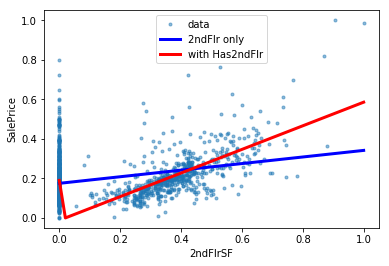

In [34]:
#PROBLEM OF LOTS OF ZEROS EXAMPLE -2ndFlrSF
#####
# mode only using 2ndflrsf
#####
tmp = scale_minmax(df_all[['SalePrice','2ndFlrSF','Has2ndFlrSF']].dropna())

y = tmp.SalePrice
X = tmp['2ndFlrSF']

plt.plot(X,y,'.',label='data',alpha=0.5)

lr = LinearRegression()
lr.fit(X.values.reshape(-1, 1),y)
lr_coefs = pd.Series(lr.coef_,index=['Has2ndFlrSF'])
lr_intercept = lr.intercept_

def regval(flr2ndSF):
    return flr2ndSF*lr_coefs + lr_intercept

plt.plot([0,1],[regval(0),regval(1)],'b',linewidth=3,label='2ndFlr only')

#####
# model using has2ndflr dummy variable
#####
tmp = scale_minmax(df_all[['SalePrice','2ndFlrSF','Has2ndFlrSF']].dropna())

y = tmp.SalePrice

X = tmp.drop('SalePrice',axis=1)

lr = LinearRegression()
lr.fit(X,y)
lr_coefs = pd.Series(lr.coef_,index=X.columns)
lr_intercept = lr.intercept_

def regval(flr2ndSF,has2nd):
    return flr2ndSF*lr_coefs['2ndFlrSF'] + has2nd*lr_coefs['Has2ndFlrSF'] + lr_intercept

plt.plot([0,0.02,1],[regval(0,0),regval(0.02,1),regval(1,1)],'r',linewidth=3,label='with Has2ndFlr')

plt.legend()
plt.xlabel('2ndFlrSF')
plt.ylabel('SalePrice');

## Distribution of SalePrice

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


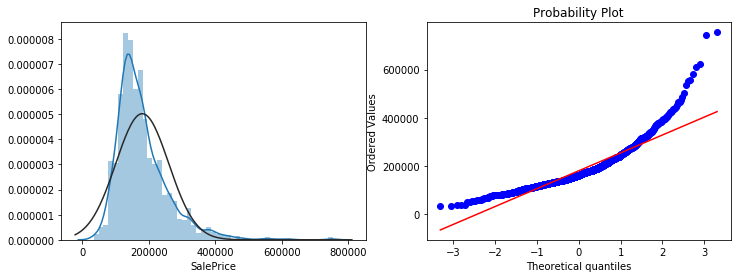

In [35]:
print(df_all.SalePrice.describe())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(df_all.SalePrice.dropna() , fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(df_all.SalePrice.dropna(), plot=plt)

## Log Transform SalePrice

count    1460.000000
mean       12.024051
std         0.399452
min        10.460242
25%        11.775097
50%        12.001505
75%        12.273731
max        13.534473
Name: SalePrice, dtype: float64


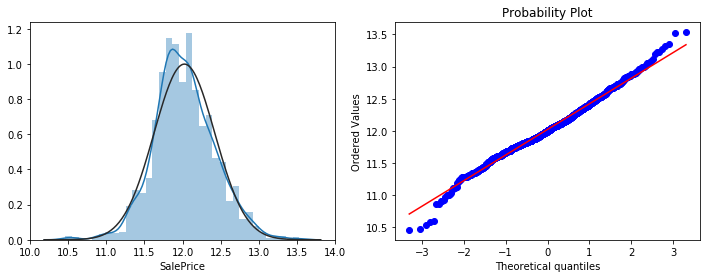

In [36]:
#Log Transform SalePrice to improve normality
sp = df_all.SalePrice
df_all.SalePrice = np.log(sp)

print(df_all.SalePrice.describe())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(sp.dropna() , fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(sp.dropna(), plot=plt)

## Identify Types of Features

In [37]:
# extract names of numeric columns
dtypes = df_all.dtypes
cols_numeric = dtypes[dtypes != object].index.tolist()

# MSubClass should be treated as categorical
cols_numeric.remove('MSSubClass')

# choose any numeric column with less than 13 values to be
# "discrete". 13 chosen to include months of the year.
# other columns "continuous"
col_nunique = dict()

for col in cols_numeric:
    col_nunique[col] = df_all[col].nunique()
    
col_nunique = pd.Series(col_nunique)

cols_discrete = col_nunique[col_nunique<13].index.tolist()
cols_continuous = col_nunique[col_nunique>=13].index.tolist()

print(len(cols_numeric),'numeric columns, of which',
      len(cols_continuous),'are continuous and',
      len(cols_discrete),'are discrete.')

82 numeric columns, of which 37 are continuous and 45 are discrete.


In [38]:
# extract names of categorical columns
cols_categ = dtypes[~dtypes.index.isin(cols_numeric)].index.tolist()

for col in cols_categ:
    df_all[col] = df_all[col].astype('category')
    
print(len(cols_categ),'categorical columns.')

25 categorical columns.


## Distribution of SalePrice in Categorical Variables

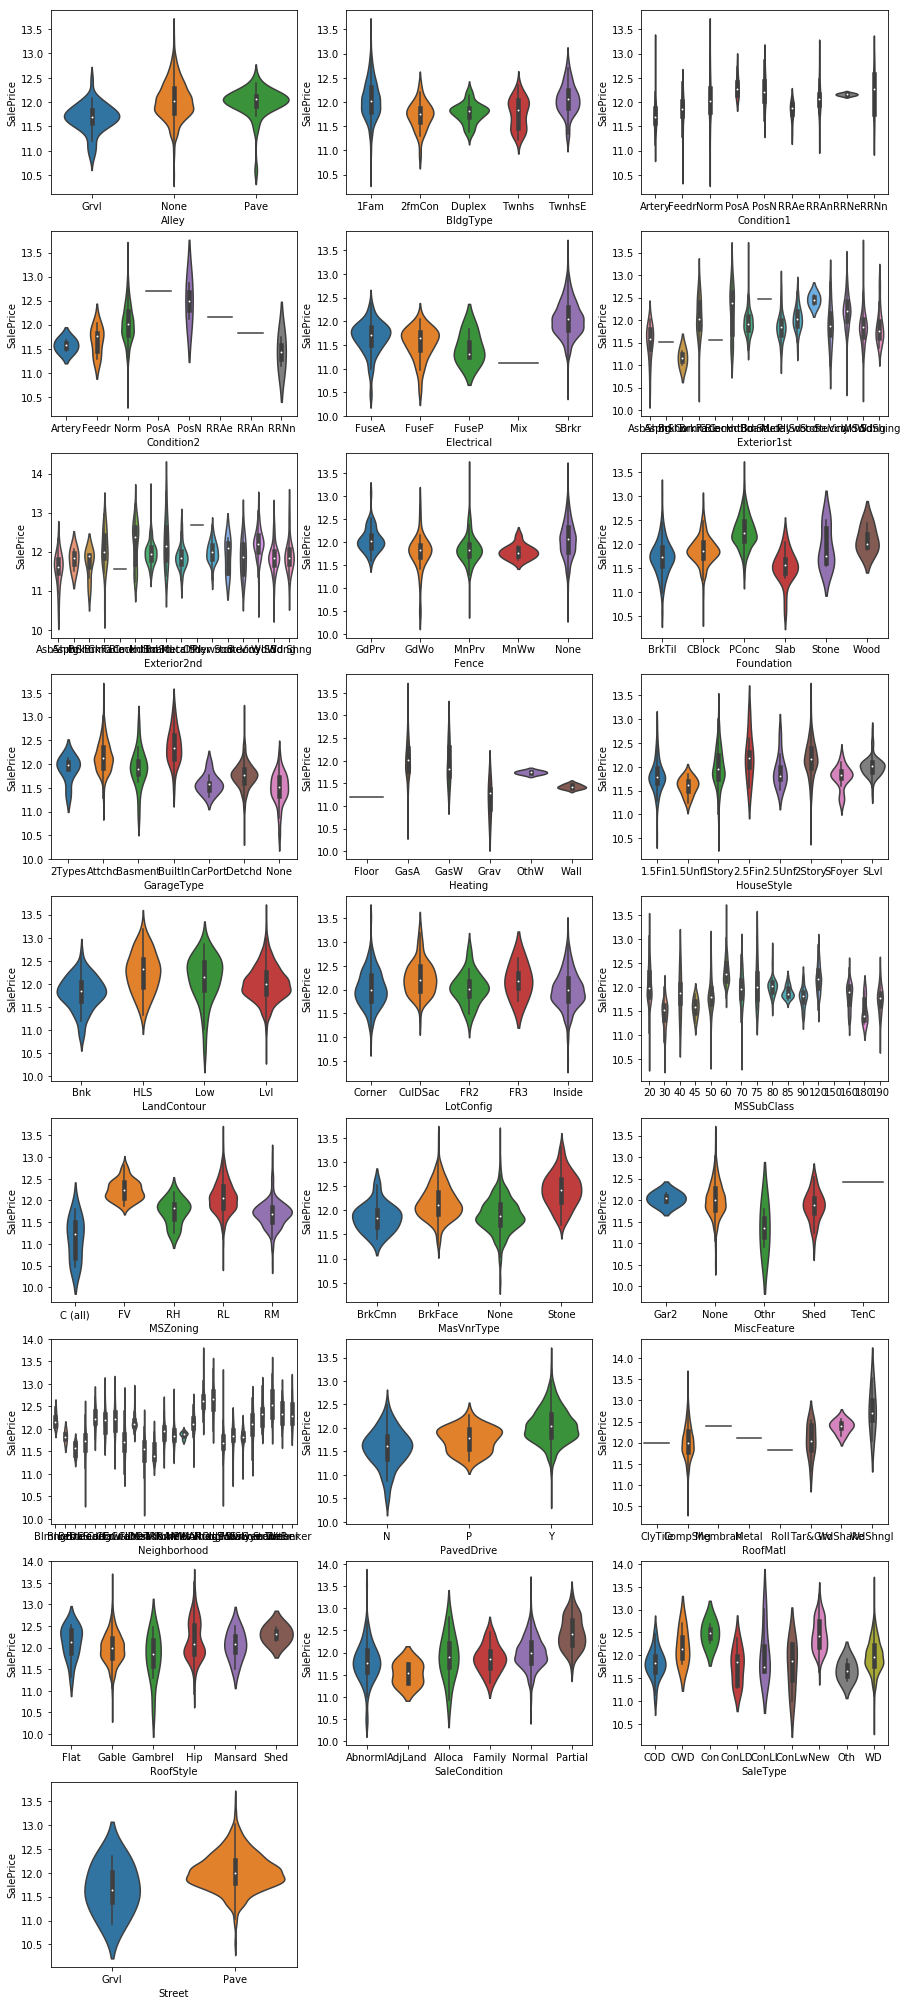

In [39]:
# plot categorical variables
fcols = 3
frows = ceil(len(cols_categ)/fcols)
plt.figure(figsize=(15,4*frows))

for i,col in enumerate(cols_categ):
    plt.subplot(frows,fcols,i+1)
    sns.violinplot(df_all[col],df_all['SalePrice'])

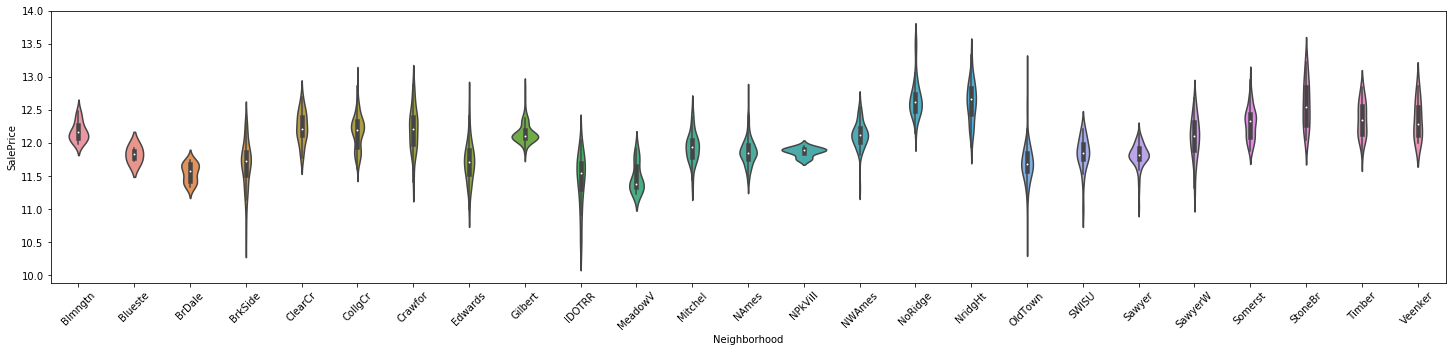

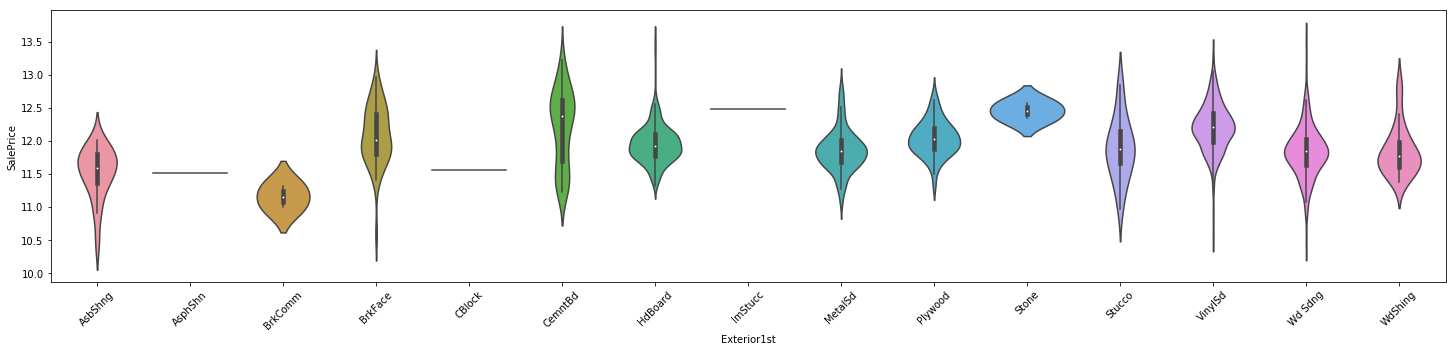

In [40]:
# few bigger plots for features with too many categories to see above

#Neighbourhood
plt.figure(figsize=(25,5))
sns.violinplot(x='Neighborhood',y='SalePrice',data=df_all)
plt.xticks(rotation=45);

#Exterior1st
plt.figure(figsize=(25,5))
sns.violinplot(x='Exterior1st',y='SalePrice',data=df_all)
plt.xticks(rotation=45);

## Significance of Categorical Features for SalePrice

In [41]:
# anova test to check significance of variation in column 'group' vs. column 'value' 
def anova(group,value):
    # select columns of interest, and remove any rows with nan values
    data = df_all[[group,value]]
    data = data[~(data[group].isnull() | data[value].isnull())]
    
    # stats across all data
    tot_groups = data[group].nunique() # no. of groups
    len_data = len(data) # total sample size of houses (all groups)
    mean_data = data[value].mean() # mean across all groups
    df_betwn = tot_groups - 1 # degrees of freedom betwn grps
    df_within = len_data - tot_groups # degrees of freedom within grps
    
    # per group stats
    n_in_group = data.groupby(group)[value].count() # no. houses in group
    mean_group = data.groupby(group)[value].mean() # mean value in this group
    
    # between-group variability
    betwn_var = n_in_group*((mean_group - mean_data)**2)
    betwn_var = float(betwn_var.sum())/df_betwn
    
    # within-group variability
    within_var = 0
    for grp in data[group].unique():
        samples = data.loc[data[group]==grp, value]
        within_var += ((samples-mean_group[grp])**2).sum()
        
    within_var = float(within_var)/df_within
    
    #F-test statistic
    F = betwn_var/within_var
    
    # p-value
    p = stats.f.sf(F, df_betwn, df_within)
    
    return p

In [42]:
# check significance of categorical variables on SalePrice
p_col = dict()

for col in cols_categ:
    p_col[col] = anova(col,'SalePrice')
    
pd.Series(p_col).sort_values()

Neighborhood     4.043304e-243
GarageType       8.427845e-125
MSSubClass       5.096023e-115
Foundation       1.350671e-111
MasVnrType        1.670061e-65
MSZoning          1.021343e-59
Exterior1st       1.053128e-53
Exterior2nd       2.429938e-49
SaleCondition     1.689708e-41
SaleType          5.497893e-36
PavedDrive        1.090995e-31
Electrical        6.081144e-31
HouseStyle        1.636077e-30
Fence             6.560319e-13
RoofStyle         1.705740e-12
BldgType          3.436794e-12
Condition1        1.173444e-10
Alley             1.358108e-09
Heating           2.484312e-09
LandContour       3.086224e-08
LotConfig         6.214575e-07
RoofMatl          4.504239e-04
MiscFeature       6.059928e-03
Condition2        1.382042e-02
Street            2.837931e-02
dtype: float64

## Distribution of SalePrice in Discrete Numeric Features

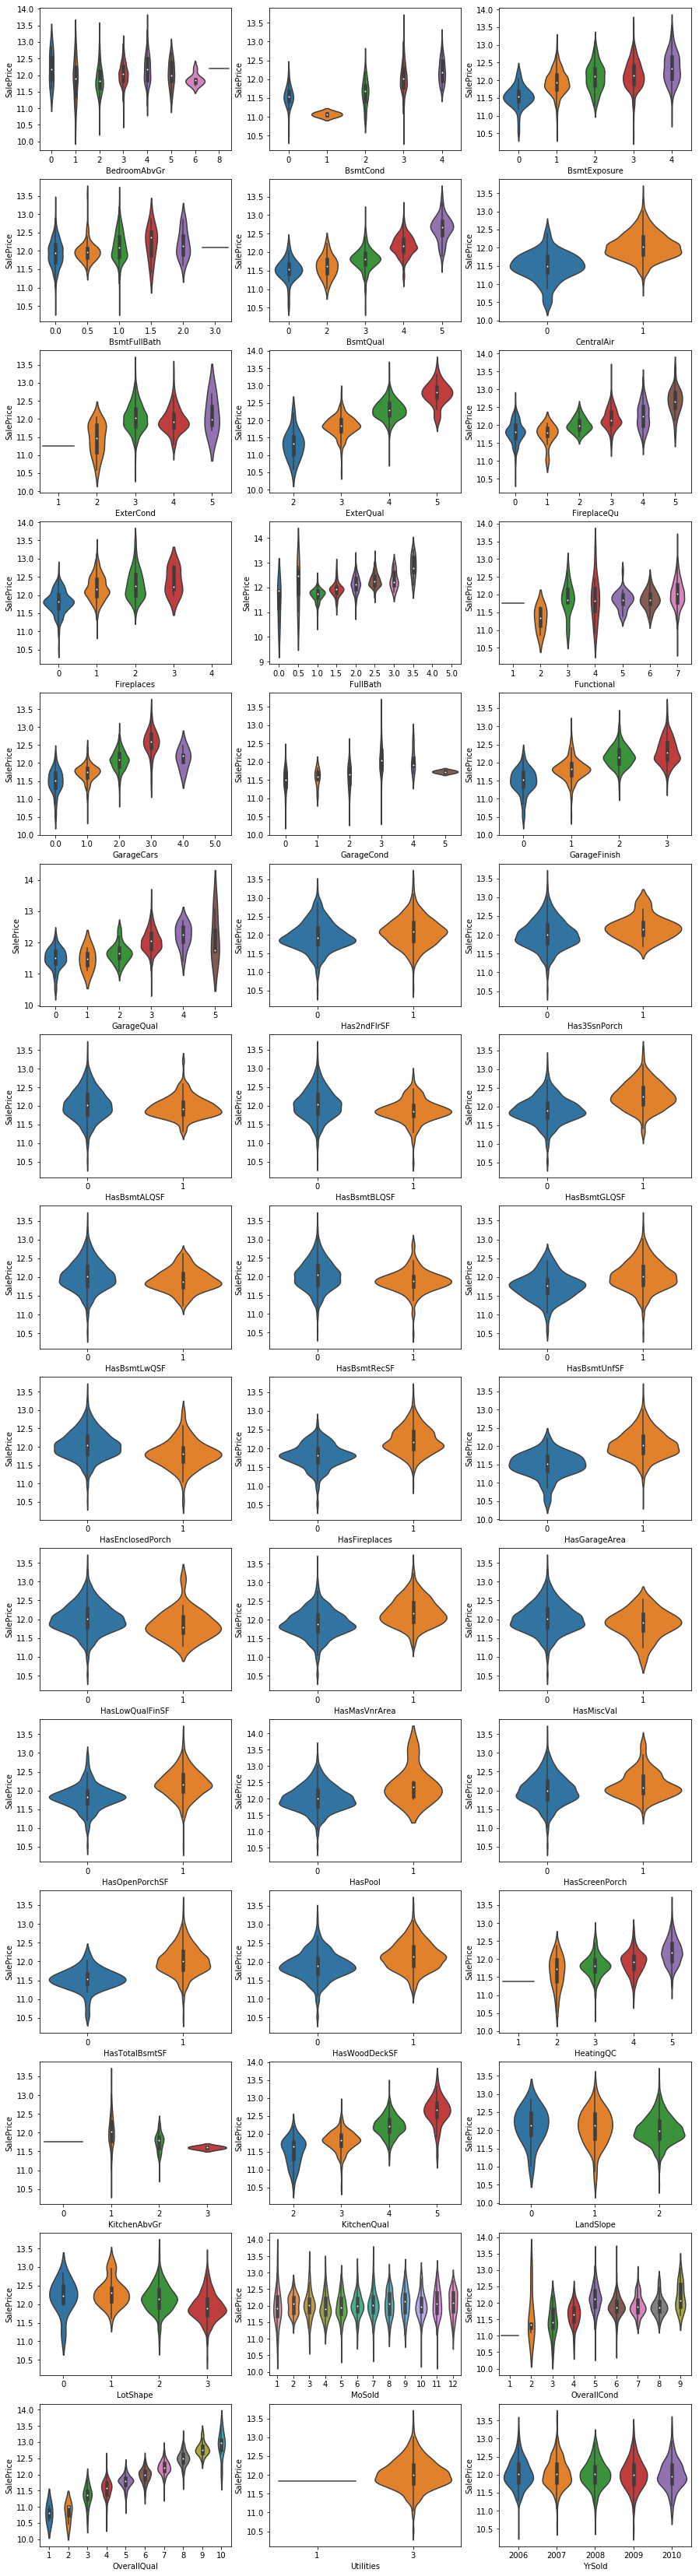

In [43]:
# figure parameters
fcols = 3
frows = ceil(len(cols_discrete)/fcols)
plt.figure(figsize=(15,4*frows))

for i,col in enumerate(cols_discrete):
    plt.subplot(frows,fcols,i+1)
    sns.violinplot(df_all[col],df_all['SalePrice'])

## Significance of Discrete Numeric Features for SalePrice

In [44]:
p_col = dict()

for col in cols_discrete:
    p_col[col] = anova(col,'SalePrice')
    
pd.Series(p_col).sort_values()

OverallQual          0.000000e+00
GarageCars          5.539585e-211
ExterQual           6.935425e-195
BsmtQual            2.031282e-188
KitchenQual         4.441486e-187
FullBath            3.733271e-167
GarageFinish        4.057458e-151
FireplaceQu         6.963458e-115
HasFireplaces        1.688600e-97
Fireplaces           7.485912e-97
HeatingQC            1.614882e-82
HasOpenPorchSF       2.024867e-73
HasBsmtGLQSF         3.828370e-69
OverallCond          9.270535e-53
HasMasVnrArea        5.246135e-52
GarageCond           2.508058e-47
BsmtExposure         2.590707e-47
GarageQual           6.068406e-46
CentralAir           9.855628e-44
HasGarageArea        8.411473e-37
HasWoodDeckSF        3.391236e-36
LotShape             7.856968e-29
BsmtCond             1.492754e-27
BedroomAbvGr         2.473588e-20
BsmtFullBath         2.301539e-17
HasEnclosedPorch     5.905933e-17
HasTotalBsmtSF       1.370151e-14
ExterCond            6.540305e-14
HasBsmtUnfSF         1.603646e-13
Has2ndFlrSF   

## Distribution of Continuous Numeric Variables and Effect on SalePrice

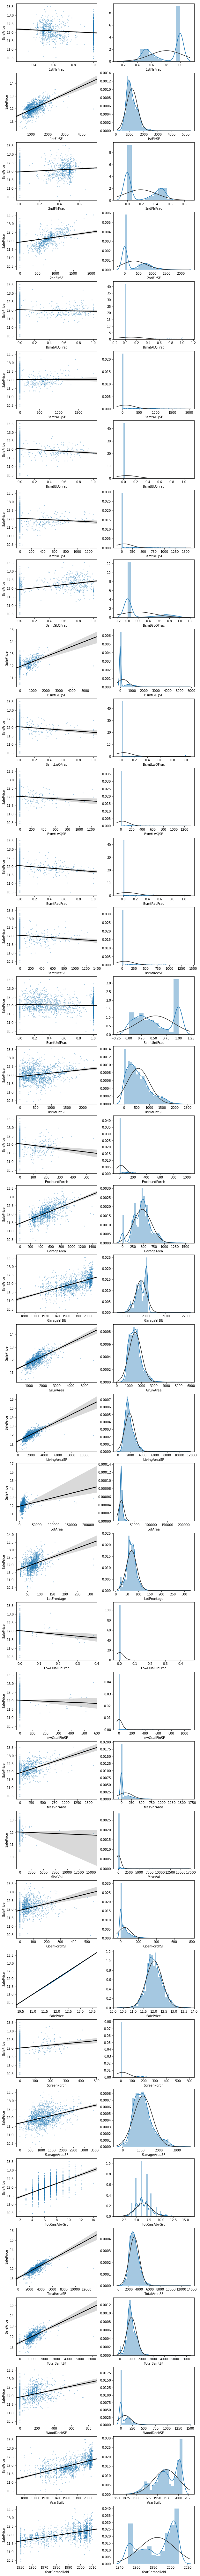

In [45]:
# figure parameters
fcols = 2
frows = len(cols_continuous)
plt.figure(figsize=(5*fcols,4*frows))

i=0
for col in cols_continuous:
    i+=1
    ax=plt.subplot(frows,fcols,i)
    sns.regplot(x=col, y='SalePrice', data=df_all, ax=ax, 
                scatter_kws={'marker':'.','s':3,'alpha':0.3},
                line_kws={'color':'k'});
    plt.xlabel(col)
    plt.ylabel('SalePrice')
    
    i+=1
    ax=plt.subplot(frows,fcols,i)
    sns.distplot(df_all[col].dropna() , fit=stats.norm)
    plt.xlabel(col)

## Correlation Between Numeric Features

SalePrice        1.000000
TotalAreaSF      0.834994
OverallQual      0.809829
LivingAreaSF     0.753706
GrLivArea        0.731310
GarageCars       0.690711
ExterQual        0.684014
BsmtQual         0.678026
FullBath         0.675455
KitchenQual      0.672849
YearBuilt        0.652682
GarageArea       0.649379
GarageFinish     0.633974
GarageYrBlt      0.612604
TotalBsmtSF      0.602725
1stFlrSF         0.575408
YearRemodAdd     0.571159
FireplaceQu      0.537602
TotRmsAbvGrd     0.532586
HasFireplaces    0.525735
Name: SalePrice, dtype: float64
-----------------
Has3SsnPorch    0.065329
HasMiscVal      0.063389
MiscVal         0.062727
BsmtALQSF       0.061374
HasPool         0.058428
LandSlope       0.050310
BsmtUnfFrac     0.036628
YrSold          0.029899
Utilities       0.016710
ExterCond       0.011682
Name: SalePrice, dtype: float64


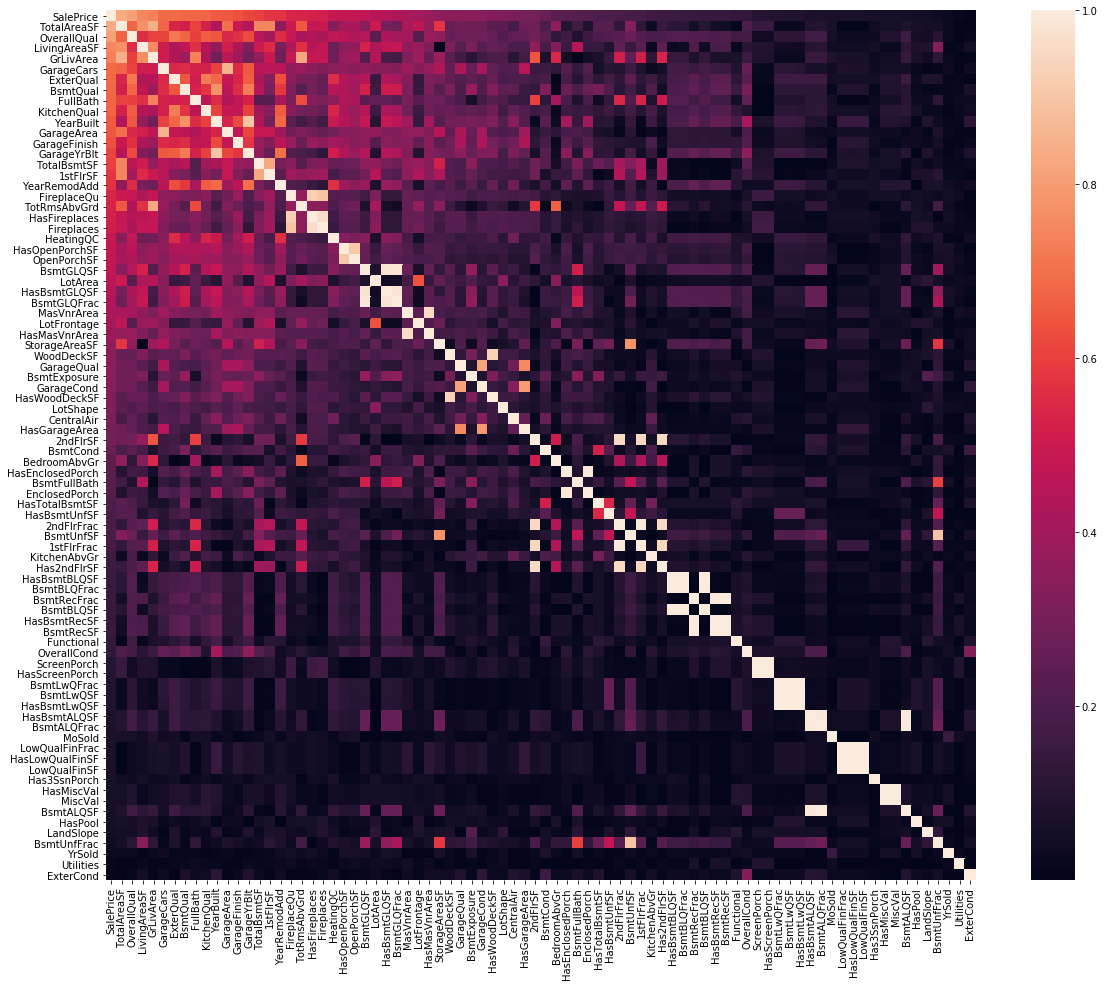

In [77]:
# correlation between numeric variables
df_corr = df_all.loc[id_train, cols_numeric].corr(method='spearman').abs()

# order columns and rows by correlation with SalePrice
df_corr = df_corr.sort_values('SalePrice',axis=0,ascending=False).sort_values('SalePrice',axis=1,ascending=False)

print(df_corr.SalePrice.head(20))
print('-----------------')
print(df_corr.SalePrice.tail(10))

ax=plt.figure(figsize=(20,16)).gca()
sns.heatmap(df_corr,ax=ax,square=True)

## Collinearity

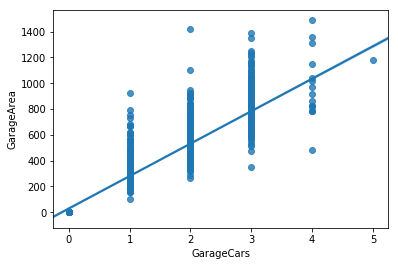

In [78]:
sns.regplot(x='GarageCars',y='GarageArea',data=df_all)

## Normalise Numeric Features

In [79]:
# normalise numeric columns
scale_cols = [col for col in cols_numeric if col!='SalePrice']
df_all[scale_cols] = df_all[scale_cols].apply(scale_minmax,axis=0)
df_all[scale_cols].describe()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFullBath,BsmtQual,BsmtUnfSF,CentralAir,EnclosedPorch,...,HasMasVnrArea,HasGarageArea,HasFireplaces,HasBsmtGLQSF,HasBsmtALQSF,HasBsmtBLQSF,HasBsmtRecSF,HasBsmtLwQSF,HasBsmtUnfSF,HasTotalBsmtSF
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,...,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,0.173405,0.162946,0.357528,0.729616,0.405961,0.153420,0.695512,0.239974,0.932854,0.022824,...,0.396711,0.945872,0.513532,0.302501,0.164782,0.114765,0.134635,0.082563,0.917095,0.972936
std,0.082412,0.207604,0.102837,0.143737,0.267506,0.173593,0.181090,0.188181,0.250318,0.063482,...,0.489299,0.226309,0.499902,0.459420,0.371048,0.318793,0.341392,0.275267,0.275786,0.162298
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.113842,0.000000,0.250000,0.750000,0.250000,0.000000,0.600000,0.094178,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,0.157110,0.000000,0.375000,0.750000,0.250000,0.000000,0.800000,0.199914,1.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,0.221277,0.340920,0.375000,0.750000,0.500000,0.333333,0.800000,0.344606,1.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
